# Introduction

Molly Siebecker and Marley Myrianthopoulos

CUNY SPS

DATA 620

Summer 2024

[Presentation Video](https://drive.google.com/file/d/19ybfab2x3ZqUBLrUCQk8bEapBxr5pmd7/view?usp=sharing)

These data sets (one for nodes and one for edges) record connections between Spotify artists, as measured by their features. We obtained the data [here](https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?select=edges.csv), originally taken from the Spotify API. When one artist is featured on another artist's song, that feature is recorded as an undirected link. The nodes data set includes each artist's name, Spotify ID, number of followers, popularity ranking, associated genres, and number of chart hits in various countries. In the edges data set, each observation represents a collaboration between artists. There are two columns, one for each ID of the artists collaborating.

Since this data includes over 130,000 artists, we will limit the scope of the investigation to only the most popular artists by filtering the data based on number of Spotify followers. After mapping their connections, we will group them by genre to divide them into categorical groups. We will then compute three measures of centrality (degree centrality, normalized degree centrality, and eigenvector centrality) both for each artist and for each genre. This will allow us to compare which genres have higher levels of collaboration in general, and could hypothetically be used to predict centrality measures for other top artists within a known genre.

# Loading and Inspecting the Data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(24)

# Read the edges CSV file into a DataFrame
edges_df = pd.read_csv('https://raw.githubusercontent.com/Marley-Myrianthopoulos/cunysps_data620/main/620_project1_edges.csv')

# Read the nodes CSV file into a DataFrame
nodes_df = pd.read_csv('https://raw.githubusercontent.com/Marley-Myrianthopoulos/cunysps_data620/main/620_project1_nodes.csv')

nodes_df.head()

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"['nordic house', 'russelater']",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...","['at (1)', 'de (1)']"
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",['se (6)']


The data frame includes tens of thousands of artists, so we filtered it to only the top 100 artists, determined by number of followers. We also mapped the Spotify IDs to artists' names so that we could change the values in the edges_df from IDs to names, for ease of analysis later.

In [2]:
# filters for top 100 artists

nodes_df = nodes_df.sort_values(by='followers', ascending = False)


nodes_df = nodes_df.head(100)

edges_df = edges_df[edges_df['id_0'].isin(nodes_df['spotify_id'])]
edges_df = edges_df[edges_df['id_1'].isin(nodes_df['spotify_id'])]

# maps names to id's

mapping_dict = dict(zip(nodes_df['spotify_id'], nodes_df['name']))

edges_df['id_0'] = edges_df['id_0'].map(mapping_dict)
edges_df['id_1'] = edges_df['id_1'].map(mapping_dict)

edges_df.head()

,id_0,id_1
174,Nicki Minaj,Post Malone
631,Avicii,Imagine Dragons
3861,Nicky Jam,Bad Bunny
3897,Khalid,Shawn Mendes
4599,Ozuna,Doja Cat


Below, we created a graph of the connections. Each node represents an artist, and each edge represents a feature.

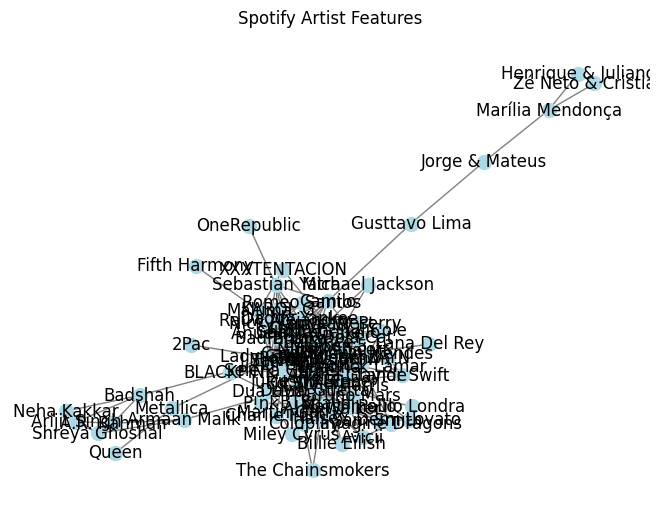

In [3]:
# initializes graph
graph = nx.Graph()


# adds edges to the graph
for index, row in edges_df.iterrows():
    graph.add_edge(row['id_0'], row['id_1'])

# draws graph
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=100, edge_color='gray')
plt.title('Spotify Artist Features')
plt.show()

# Data Transformation

We inspected the first five rows of the top 100 artists, sorted by number of followers. We also inspected the unique artist names and the unique genres.

In [4]:
nodes_df.head()

,spotify_id,name,followers,popularity,genres,chart_hits
14198,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,102156853.0,90,"['pop', 'uk pop']","['us (52)', 'gb (83)', 'ar (36)', 'au (65)', '..."
17604,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,83045090.0,88,"['dance pop', 'pop']","['us (81)', 'gb (69)', 'ar (36)', 'au (70)', '..."
18188,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,68407227.0,88,"['art pop', 'electropop', 'pop']","['us (46)', 'gb (43)', 'ar (23)', 'au (45)', '..."
18726,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,"['canadian hip hop', 'canadian pop', 'hip hop'...","['us (190)', 'gb (163)', 'ar (18)', 'au (148)'..."
6237,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,65590075.0,90,"['canadian pop', 'pop']","['us (58)', 'gb (51)', 'ar (29)', 'au (54)', '..."


In [5]:
nodes_df['name'].unique()

array(['Ed Sheeran', 'Ariana Grande', 'Billie Eilish', 'Drake',
       'Justin Bieber', 'Eminem', 'Taylor Swift', 'Arijit Singh',
       'Bad Bunny', 'BTS', 'Rihanna', 'The Weeknd', 'Bruno Mars', 'Queen',
       'Adele', 'Imagine Dragons', 'Shawn Mendes', 'Coldplay',
       'Post Malone', 'XXXTENTACION', 'Maroon 5', 'Neha Kakkar',
       'Selena Gomez', 'Dua Lipa', 'J Balvin', 'Alan Walker',
       'Marshmello', 'Ozuna', 'BLACKPINK', 'Maluma', 'Beyoncé',
       'Daddy Yankee', 'KAROL G', 'Camila Cabello', 'One Direction',
       'Marília Mendonça', 'Nicki Minaj', "Guns N' Roses", 'Juice WRLD',
       'Shakira', 'David Guetta', 'AC/DC', 'Sia', 'Michael Jackson',
       'A.R. Rahman', 'Anuel AA', 'The Beatles', 'Harry Styles',
       'Demi Lovato', 'Lady Gaga', 'Calvin Harris', 'Twenty One Pilots',
       'Katy Perry', 'Metallica', 'Avicii', 'Doja Cat', 'Linkin Park',
       'Kendrick Lamar', 'ZAYN', 'Badshah', 'Travis Scott',
       'Olivia Rodrigo', 'Cardi B', 'Sam Smith', 'Sebastian Y

In [6]:
nodes_df['genres'].unique()

array(["['pop', 'uk pop']", "['dance pop', 'pop']",
       "['art pop', 'electropop', 'pop']",
       "['canadian hip hop', 'canadian pop', 'hip hop', 'rap', 'toronto rap']",
       "['canadian pop', 'pop']", "['detroit hip hop', 'hip hop', 'rap']",
       "['pop']", "['desi pop', 'filmi', 'modern bollywood']",
       "['reggaeton', 'trap latino']", "['k-pop', 'k-pop boy group']",
       "['barbadian pop', 'dance pop', 'pop', 'urban contemporary']",
       "['canadian contemporary r&b', 'canadian pop', 'pop']",
       "['classic rock', 'glam rock', 'rock']",
       "['british soul', 'pop', 'pop soul', 'uk pop']",
       "['modern rock', 'rock']",
       "['canadian pop', 'dance pop', 'pop', 'viral pop']",
       "['permanent wave', 'pop']", "['dfw rap', 'melodic rap', 'rap']",
       "['emo rap', 'miami hip hop']",
       "['dance pop', 'pop', 'post-teen pop', 'uk pop']",
       "['dance pop', 'pop', 'uk pop']",
       "['reggaeton', 'reggaeton colombiano', 'trap latino']",
       "['e

Almost all the artists are linked to multiple genres, but these genres are often slight variations of each other (for example, "dance pop, pop, post-teen pop, UK pop.") For the purpose of our analysis, we reassigned the genres by hand, using only 8 "umbrella" genres: Desi pop, EDM, hip hop, K-pop, Latin music, reggaeton & Latin trap, pop, and rock. The artist in the example above (One Direction) was reassigned to "pop."

In [7]:
# new lists of genres and associated artists

desi_pop_artists = ['Badshah', 'Neha Kakkar', 'Arijit Singh', 'Shreya Ghoshal', 'Armaan Malik', 'A.R. Rahman']
edm_artists = ['David Guetta', 'The Chainsmokers', 'Martin Garrix', 'Avicii', 'Alan Walker', 'Calvin Harris', 'Marshmello']
hip_hop_artists = ['J. Cole', 'Lil Uzi Vert', 'XXXTENTACION', '2Pac', 'Post Malone', 'Travis Scott', 'Drake', 'Kanye West', 'Cardi B', 'Eminem', 'Nicki Minaj', 'Juice WRLD', 'Kendrick Lamar']
k_pop_artists = ['TWICE', 'BTS', 'BLACKPINK']
latin_music_artists = ['Marília Mendonça', 'Camilo', 'Zé Neto & Cristiano', 'Henrique & Juliano', 'Romeo Santos', 'Banda MS de Sergio Lizárraga', 'Shakira', 'Jorge & Mateus', 'Gusttavo Lima', 'Sebastian Yatra']
reggaeton_latin_trap_artists = ['Bad Bunny', 'Paulo Londra', 'Daddy Yankee', 'Anuel AA', 'Nicky Jam', 'Maluma', 'Rauw Alejandro', 'J Balvin', 'Ozuna', 'KAROL G', 'Farruko']
pop_artists = ['Khalid', 'Demi Lovato', 'Doja Cat', 'Bruno Mars', 'Chris Brown', 'The Weeknd', 'Ed Sheeran', 'Lana Del Rey', 'Rihanna', 'Maroon 5', 'P!nk', 'Harry Styles', 'Halsey', 'Ariana Grande', 'Adele', 'Billie Eilish', 'Katy Perry', 'Sam Smith', 'Shawn Mendes', 'Dua Lipa', 'OneRepublic', 'Camila Cabello', 'One Direction', 'ZAYN', 'Melanie Martinez', 'Fifth Harmony', 'Taylor Swift', 'Beyoncé', 'Olivia Rodrigo', 'Michael Jackson', 'Justin Bieber', 'Miley Cyrus', 'Charlie Puth', 'Coldplay', 'Lady Gaga', 'Selena Gomez', 'Sia']
rock_artists = ['Metallica', 'The Beatles', 'Pink Floyd', 'Red Hot Chili Peppers', 'Arctic Monkeys', 'Twenty One Pilots', 'AC/DC', 'Nirvana', "Guns N' Roses", 'Queen', 'Imagine Dragons', 'Green Day', 'Linkin Park']

In [8]:
# replaces genres in nodes_df with new assignments

def replace_genre(row):
    if row['name'] in desi_pop_artists:
        return 'desi pop'
    elif row['name'] in edm_artists:
        return 'edm'
    elif row['name'] in hip_hop_artists:
        return 'hip hop'
    elif row['name'] in k_pop_artists:
        return 'k_pop'
    elif row['name'] in latin_music_artists:
        return 'latin music'
    elif row['name'] in reggaeton_latin_trap_artists:
        return 'reggaeton & latin trap'
    elif row['name'] in pop_artists:
        return 'pop'
    elif row['name'] in rock_artists:
        return 'rock'
    else:
        print('There is an artist without a genre.')


nodes_df['genres'] = nodes_df.apply(replace_genre, axis=1)
nodes_df = nodes_df.rename(columns={'genres': 'genre'})
nodes_df.head()

,spotify_id,name,followers,popularity,genre,chart_hits
14198,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,102156853.0,90,pop,"['us (52)', 'gb (83)', 'ar (36)', 'au (65)', '..."
17604,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,83045090.0,88,pop,"['us (81)', 'gb (69)', 'ar (36)', 'au (70)', '..."
18188,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,68407227.0,88,pop,"['us (46)', 'gb (43)', 'ar (23)', 'au (45)', '..."
18726,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,hip hop,"['us (190)', 'gb (163)', 'ar (18)', 'au (148)'..."
6237,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,65590075.0,90,pop,"['us (58)', 'gb (51)', 'ar (29)', 'au (54)', '..."


# Highest Centrality Nodes

Next, we go back to the DataFrame with the nodes and, for each node, calculate the centrality measures of degree (number of edges connecting to the node), normalized degree centrality (degree divided by number of possible edges, which is number of nodes minus one), and eigenvector centrality for that node. We create three new columns in the DataFrame to include this data for each node, then create a new DataFrame which just has the name and genre for each node as well as its centrality measures.

In [9]:

# Calculates degree centrality and eigenvector centrality for each node, creating a column for each
node_centrality = dict(nx.degree(graph))
nodes_df['degree'] = nodes_df['name'].apply(lambda name: node_centrality.get(name))

normed_centrality = nx.degree_centrality(graph)
nodes_df['normed_degree'] = nodes_df['name'].apply(lambda name: normed_centrality.get(name))

eigen_centrality = nx.eigenvector_centrality(graph)
nodes_df['eigen_centrality'] = nodes_df['name'].apply(lambda name: eigen_centrality.get(name))

centrality_df = nodes_df.filter(['name', 'genre', 'degree', 'normed_degree', 'eigen_centrality'])

By sorting the centrality_df DataFrame we are now able to identify the top 5 nodes for the different centrality measures (note that degree and normalized degree centrality will give the same result).

In [10]:
# Shows top 5 artists by normalized degree centrality
print(centrality_df.sort_values(by = 'normed_degree', ascending = False).head())

                name                   genre  degree  normed_degree  \
18411       J Balvin  reggaeton & latin trap    24.0       0.292683   
606      Nicki Minaj                 hip hop    23.0       0.280488   
17754   David Guetta                     edm    19.0       0.231707   
13879     The Weeknd                     pop    19.0       0.231707   
6237   Justin Bieber                     pop    18.0       0.219512   

       eigen_centrality  
18411          0.284187  
606            0.259155  
17754          0.177515  
13879          0.188099  
6237           0.193040  


In [11]:
# Shows top 5 artists by eigenvector centrality
print(centrality_df.sort_values(by = 'eigen_centrality', ascending = False).head())

              name                   genre  degree  normed_degree  \
18411     J Balvin  reggaeton & latin trap    24.0       0.292683   
606    Nicki Minaj                 hip hop    23.0       0.280488   
11203    Bad Bunny  reggaeton & latin trap    15.0       0.182927   
7897       Farruko  reggaeton & latin trap    15.0       0.182927   
5014         Ozuna  reggaeton & latin trap    16.0       0.195122   

       eigen_centrality  
18411          0.284187  
606            0.259155  
11203          0.225474  
7897           0.217232  
5014           0.211990  


# Highest Centrality Genres

By grouping the data frame by genre, we can compare average and median degree and eigenvector centrality across genres.

In [12]:
# Calculating mean degree and eigenvector centrality across genres
print("Means:")
print(centrality_df.groupby('genre')[['degree', 'normed_degree', 'eigen_centrality']].mean())

print("\n")
print("Medians:")
# Calculating median degree and eigenvector centrality across genres
print(centrality_df.groupby('genre')[['degree', 'normed_degree', 'eigen_centrality']].median())

Means:
                           degree  normed_degree  eigen_centrality
genre                                                             
desi pop                 3.666667       0.044715          0.007596
edm                      8.000000       0.097561          0.068306
hip hop                 10.307692       0.125704          0.120753
k_pop                    5.500000       0.067073          0.046654
latin music              4.777778       0.058266          0.047272
pop                      6.593750       0.080412          0.070235
reggaeton & latin trap  13.181818       0.160754          0.183094
rock                     2.000000       0.024390          0.015340


Medians:
                        degree  normed_degree  eigen_centrality
genre                                                          
desi pop                   4.0       0.048780          0.002993
edm                        6.0       0.073171          0.045166
hip hop                   11.0       0.134146          0

Regardless of whether the mean or median is considered, and regardless of whether we use degree centrality or eigenvector centrality, Hip Hop and Reggaeton/Latin Trap have the highest centrality. This is consistent with what we would expect from the structure of the data, edges represent features and these two genres have well established norms of collaboration between artists.

Additionally, regardless of whether the mean or median is concerned, Rock music has the lowest degree centrality and Desi Pop has the lowest eigenvector centrality. Again, this matches our expectations, rock does not have an established norm of collaboration between artists, and Desi Pop artists mostly collaborate within their own genre, as shown below.

In [13]:
print("Rock Artists:")

rock_artists = nodes_df[nodes_df['genre'] == 'rock']['name'].unique()
print(rock_artists)

print("\nRock Features:")
rock_features = edges_df[edges_df['id_0'].isin(rock_artists) | edges_df['id_1'].isin(rock_artists)]
print(rock_features)

print("\n\nDesi Pop Artists:")

desi_artists = nodes_df[nodes_df['genre'] == 'desi pop']['name'].unique()
print(desi_artists)

print("\nDesi Pop Features:")
desi_features = edges_df[edges_df['id_0'].isin(desi_artists) | edges_df['id_1'].isin(desi_artists)]
print(desi_features)

Rock Artists:
['Queen' 'Imagine Dragons' "Guns N' Roses" 'AC/DC' 'The Beatles'
 'Twenty One Pilots' 'Metallica' 'Linkin Park' 'Red Hot Chili Peppers'
 'Pink Floyd' 'Nirvana' 'Arctic Monkeys' 'Green Day']

Rock Features:
                   id_0             id_1
631              Avicii  Imagine Dragons
85156   Imagine Dragons           Khalid
109734            Queen        Metallica
147474   Kendrick Lamar  Imagine Dragons
181672         J Balvin        Metallica


Desi Pop Artists:
['Arijit Singh' 'Neha Kakkar' 'A.R. Rahman' 'Badshah' 'Armaan Malik'
 'Shreya Ghoshal']

Desi Pop Features:
                  id_0          id_1
31593          Badshah   Neha Kakkar
47258          Badshah      J Balvin
52073      A.R. Rahman  Arijit Singh
59722      A.R. Rahman  Armaan Malik
68874   Shreya Ghoshal  Arijit Singh
111338         Badshah  Arijit Singh
162760    Armaan Malik    Ed Sheeran
174105  Shreya Ghoshal   A.R. Rahman
181744    Arijit Singh   Neha Kakkar
242986  Shreya Ghoshal   Neha Kakkar

There are 13 rock artists included in the data and only 3 of them are involved in any features (Queen, Metallica, and Imagine Dragons). There are only 6 Desi Pop artists, but they collaborate within their genre quite a bit, each of the 6 artists is involved in a feature with another Desi Pop artist. However, there are only two collaborations involving a Desi Pop artist and an artist from another genre (Badshah's collaboration with J Balvin, and Armaan Malik's collaboration with Ed Sheeran).

This demonstrates the difference between degree centrality and eigenvector centrality, the median Desi Pop artist in the data set has more collaborations than the median Rock artist, but because two of the three Rock Artists have collaborations with popular artists from other genres, the mean and median eigenvector centrality for Rock artists is higher than the mean and median eigenvector centrality for Desi Pop artists.